# League of Legends Match predictor

The following code is a toy program predicting the outcome of League of Legends matches.

In [1]:
# We start loading the required packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

# Load the dataset
data_table = pd.read_csv('league_of_legends_data_large.csv')

# Split the data into targets and features
data_targets = data_table.iloc[:,0]
data_features = data_table.iloc[:,1:-1]

# Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(data_features, data_targets, test_size=0.2, random_state=42, stratify=data_targets)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

We now build a Logistic Regression model.

In [3]:
# Define the Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_units=7, output_units=1):
        super(LogisticRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_units, output_units)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x

# Initialize the model
model = LogisticRegressionModel()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

We define the functions to train our model, we train the model and we evaluate its accuraccy.

In [4]:
def train_model(epochs = 1000):    
    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        # print loss
        if epoch % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}')

train_model()

# Evaluation phase on test set
def evaluate_model():
    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train).squeeze()
        test_outputs = model(X_test).squeeze()
    
    train_predictions = (train_outputs >= 0.5).float()
    test_predictions = (test_outputs >= 0.5).float()
    
    train_accuracy = (train_predictions == y_train).float().mean().item()
    test_accuracy = (test_predictions == y_test).float().mean().item()
    print(f'Train accuracy: {train_accuracy}, Test accuracy: {test_accuracy}')

evaluate_model()

Epoch [1/1000], Train Loss: 0.7329
Epoch [101/1000], Train Loss: 0.7191
Epoch [201/1000], Train Loss: 0.7097
Epoch [301/1000], Train Loss: 0.7034
Epoch [401/1000], Train Loss: 0.6992
Epoch [501/1000], Train Loss: 0.6964
Epoch [601/1000], Train Loss: 0.6946
Epoch [701/1000], Train Loss: 0.6934
Epoch [801/1000], Train Loss: 0.6926
Epoch [901/1000], Train Loss: 0.6921
Train accuracy: 0.5137500166893005, Test accuracy: 0.550000011920929


We now create a confusion matrix and ROC curve.

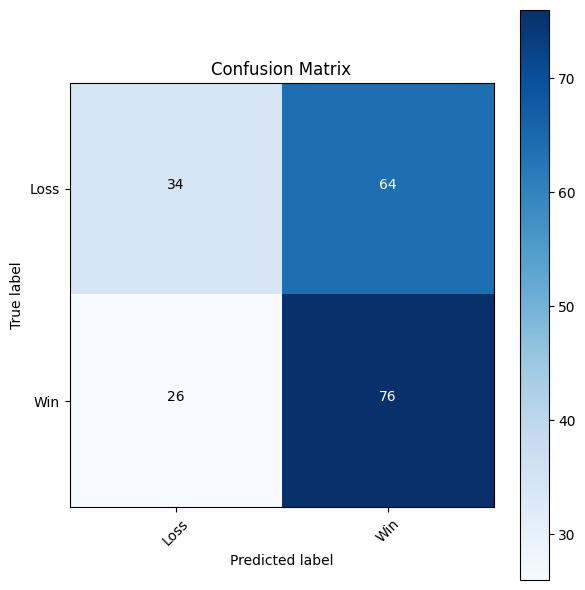

Classification Report:
               precision    recall  f1-score   support

        Loss       0.57      0.35      0.43        98
         Win       0.54      0.75      0.63       102

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.53       200
weighted avg       0.55      0.55      0.53       200



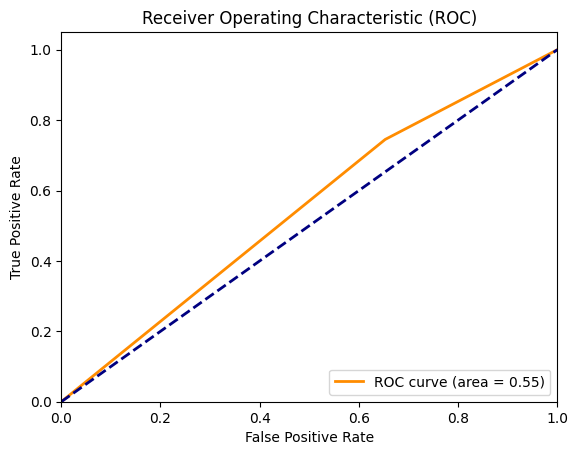

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools

# Visualize the confusion matrix
test_outputs = model(X_test).squeeze()
test_predictions = (test_outputs >= 0.5).float()
y_pred_test_labels = (test_predictions > 0.5).float()
cm = confusion_matrix(y_test, y_pred_test_labels)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['Loss', 'Win'], rotation=45)
plt.yticks(tick_marks, ['Loss', 'Win'])

thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_test_labels, target_names=['Loss', 'Win']))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Finally, we evaluate the importance of each feature in our model.

Epoch [1/1000], Train Loss: 0.7271
Epoch [101/1000], Train Loss: 0.7131
Epoch [201/1000], Train Loss: 0.7045
Epoch [301/1000], Train Loss: 0.6992
Epoch [401/1000], Train Loss: 0.6960
Epoch [501/1000], Train Loss: 0.6941
Epoch [601/1000], Train Loss: 0.6929
Epoch [701/1000], Train Loss: 0.6922
Epoch [801/1000], Train Loss: 0.6918
Epoch [901/1000], Train Loss: 0.6915
        Feature  Importance
5  wards_placed    0.058272
0         kills    0.054735
3   gold_earned    0.051625
6  wards_killed    0.020449
1        deaths    0.005919
4            cs   -0.007549
2       assists   -0.015408


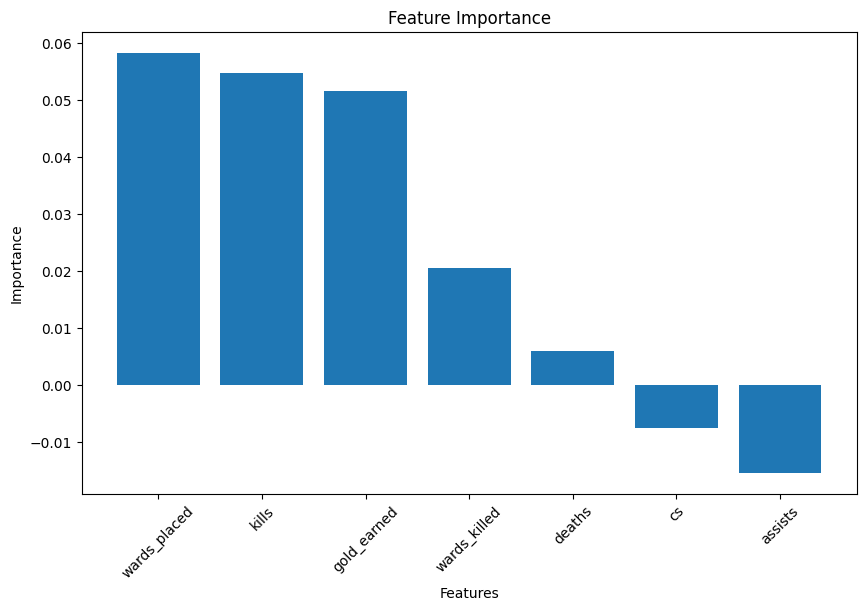

In [6]:
# Extract the weights of the linear layer
model.fc1.reset_parameters()         
torch.optim.SGD(model.parameters(), lr=0.1)
train_model(epochs=1000)
weights = model.fc1.weight.data.numpy().flatten()
features = data_features.columns

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': features, 'Importance': weights})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)
# Plot feature importance 
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()